# Reading in the data

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('winemag-data-130k-v2.csv') #read in second dataset

df = df.drop(["index"], axis = 1) # drop index column

#add column with a length of a description
df["description_len"] = df['description'].str.len()

print(df.shape)
df.head()

(129971, 14)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,description_len
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,#NAME?,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,172
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,#NAME?,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,227
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,186
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,199
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,249


# Data Exploration

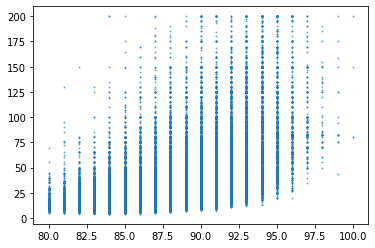

Data shows that wines with higher score tend to also be mre expensive.


In [55]:
# Check if price of the wine increases with number of points given
x = df.points[df.price <= 200]
y = df.price[df.price <= 200]
plt.scatter(x, y, s=1, alpha=0.5)
plt.show()
print("Data shows that wines with higher score tend to also be mre expensive.")

In [58]:
# Check how many tasters are there
df.taster_name.value_counts()

Roger Voss            23560
Michael Schachner     14046
Kerin O’Keefe          9697
Paul Gregutt           8868
Virginie Boone         8708
Matt Kettmann          5730
Joe Czerwinski         4766
Sean P. Sullivan       4461
Anna Lee C. Iijima     4017
Jim Gordon             3766
Anne Krebiehl MW       3290
Lauren Buzzeo          1700
Susan Kostrzewa        1023
Mike DeSimone           461
Jeff Jenssen            436
Alexander Peartree      383
Carrie Dykes            129
Fiona Adams              24
Christina Pickard         6
Name: taster_name, dtype: int64

In [59]:
#Check what's the mean score given by tasters
df.groupby(['taster_name']).mean()['points'].sort_values(ascending=False)

taster_name
Anne Krebiehl MW      90.625228
Matt Kettmann         90.061431
Virginie Boone        89.220946
Mike DeSimone         89.125813
Paul Gregutt          89.094159
Kerin O’Keefe         88.897803
Sean P. Sullivan      88.754988
Roger Voss            88.733107
Jim Gordon            88.603558
Joe Czerwinski        88.524339
Anna Lee C. Iijima    88.416480
Jeff Jenssen          88.330275
Christina Pickard     87.833333
Lauren Buzzeo         87.692941
Michael Schachner     86.857112
Fiona Adams           86.750000
Susan Kostrzewa       86.575758
Carrie Dykes          86.356589
Alexander Peartree    85.780679
Name: points, dtype: float64

In [60]:
#Check what's the mean score for different varieties 
df.groupby(['variety']).mean()['points'].sort_values(ascending=False)

variety
Gelber Traminer        95.000000
Tinta del Pais         95.000000
Terrantez              95.000000
Bual                   94.142857
Riesling-Chardonnay    94.000000
                         ...    
Aidani                 82.000000
Shiraz-Tempranillo     82.000000
Picapoll               82.000000
Airen                  81.666667
Chancellor             80.500000
Name: points, Length: 707, dtype: float64

# Cleaning the data

#### 1. Dropping duplicate rows

In [20]:
# drop any duplicate rows
print("There are ", df.duplicated(subset=None, keep='first').sum(), " duplicate rows.")
df.drop_duplicates(subset = list(df.columns), keep="first", inplace=True)
df = df.reset_index(drop=True) # reset the indexing
print("The shape of the dataset after removing the duplicate rows is: ", df.shape)

There are  9983  duplicate rows.
The shape of the dataset after removing the duplicate rows is:  (119988, 14)


#### 2. Imputing missing values

In [21]:
#Provide a set of columns with 0 missing values.
no_nulls = set(df.columns[df.isnull().mean()==0]) 
print("Columns with no missing values:",no_nulls)

Columns with no missing values: {'winery', 'description', 'title', 'description_len', 'points'}


In [52]:
#Check how many missing values we have in other columns
print("Column country has ", df[pd.isnull(df["country"])].shape[0], " missing values.")
print("Column variety has ", df[pd.isnull(df["variety"])].shape[0], " missing values.") 
print("Column price has ", df[pd.isnull(df["price"])].shape[0], " missing values.")
print("Column taster_name has ", df[pd.isnull(df["taster_name"])].shape[0], " missing values.")
print("Column winery has ", df[pd.isnull(df["winery"])].shape[0], " missing values.")
# we will be comfortable dropping rows with missing values for country or variaty due to low volumes

# we will fill the missing values for price with median for the given points range

Column country has  59  missing values.
Column variety has  1  missing values.
Column price has  0  missing values.
Column taster_name has  24917  missing values.
Column winery has  0  missing values.


In [28]:
def points_bands(points):
    '''
    This function defines what points range does wine qualify
    The input is a single value (number of points)
    The ouput is a string (defined points range)
    '''
    
    if (points >=80) & (points <85):
        return ("[80,85)")
    elif (points >=85) & (points <90):
        return ("[85,90)")
    elif (points >=90) & (points <95):
        return ("[90,95)")
    elif (points >=95) & (points <=100):
        return ("[95,100]")

#apply the function to the points column 
df["points_range"] = df.points.apply(points_bands)
df.points_range.value_counts()

[85,90)     62310
[90,95)     43198
[80,85)     12088
[95,100]     2392
Name: points_range, dtype: int64

In [33]:
#fill in missing values in price based on the points range

df.price[df.points_range == "[95,100]"].median() #85
df.price[df.points_range == "[90,95)"].median() #40
df.price[df.points_range == "[85,90)"].median() #20
df.price[df.points_range == "[80,85)"].median() #15

# define conditions and values
conditions = [df['points_range'] == "[95,100]", df['points_range'] == "[90,95)", 
              df['points_range'] == "[85,90)", df['points_range'] == "[80,85)"]
values = [82, 40, 20, 15]

# apply logic where price is null
df['price'] = np.where(df['price'].isnull(),
                              np.select(conditions, values),
                              df['price'])
        
#check if all missing values have been filled
df[pd.isnull(df["price"])].shape

(0, 15)

In [36]:
def price_bands(price):
    '''
    This function defines what points range does wine qualify
    The input is a single value (number of points)
    The ouput is a string (defined points range)
    '''
    
    if (price <20):
        return ("[0,20)")
    elif ((price >=20) & (price <40)):
        return ("[20,40)")
    elif ((price >=40) & (price <60)):
        return ("[40,60)")
    elif ((price >=60) & (price <100)):
        return ("[60,100)")
    elif ((price >=100) & (price <500)):
        return ("[100,500)")
    elif (price >=500):
        return ("[500+]")

df["price_range"] = df.price.apply(price_bands)
df.price_range.value_counts()

[20,40)      46816
[0,20)       36988
[40,60)      21440
[60,100)     10959
[100,500)     3681
[500+]         104
Name: price_range, dtype: int64

In [39]:
def get_vintage (title):
    '''
    Function to extract vintage from the wine title.
    The input is a single string (a title).
    The output is a single string (a preprocessed movie review).
    '''

    # Remove non-numbers
    vintage = [int(s) for s in title.split() if s.isdigit()]
    
    if len(vintage) == 0:
        return (0)
    else:
        for i in vintage:
            if i >= 1990 and i <= 2020: # only return numbers that suggest they represent vintage
                return(i)
            else:
                return(0)


df["vintage"] = df["title"].apply(get_vintage)
df.vintage.value_counts()

2012    14269
2013    14225
2014    13895
2011    11480
2010    11229
2009     9228
2015     8932
2008     6982
2007     6704
2006     5548
0        4990
2005     3474
2016     3289
2004     1711
2000      750
2001      684
1999      639
2003      573
1998      549
2002      357
1997      302
1996       67
1995       49
1994       23
1992       16
2017       11
1990        5
1991        4
1993        3
Name: vintage, dtype: int64

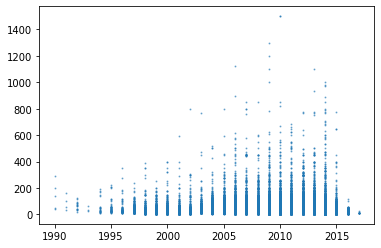

Data shows that wines with higher score tend to also be mre expensive.


In [65]:
# Check if price of the wine increases with number of points given
x = df.vintage[df.price <= 1500]
y = df.price[df.price <= 1500]
plt.scatter(x, y, s=1, alpha=0.5)
plt.show()
print("Data indicates that price of the wine might be associated with it's vinatge.")

In [49]:
#Fill in  missing values in vintage column by finding most common vintage for given price range

# Program to find most frequent element in a list 
from collections import Counter 
  
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

most_frequent(df.vintage[(df.price_range == "[0,20)") & (df.vintage != 0)]) #2014
most_frequent(df.vintage[(df.price_range == "[20,40)") & (df.vintage != 0)]) #2013
most_frequent(df.vintage[(df.price_range == "[40,60)") & (df.vintage != 0)]) #2012
most_frequent(df.vintage[(df.price_range == "[60,100)") & (df.vintage != 0)]) #2012
most_frequent(df.vintage[(df.price_range == "[100,500)") & (df.vintage != 0)]) #2012
most_frequent(df.vintage[(df.price_range == "[500+]") & (df.vintage != 0)]) #2014

# define conditions and values
conditions = [df['price_range'] == "[0,20)", df['price_range'] == "[20,40)", 
              df['price_range'] == "[40,60)", df['price_range'] == "[60,100)",
              df['price_range'] == "[100,500)", df['price_range'] == "[500+]"]
values = [2014, 2013, 2012, 2012, 2012, 2014]

# apply logic where vintage is null
df['vintage'] = np.where(df['vintage'] == 0,
                              np.select(conditions, values),
                              df['vintage'])

#check if all missing values have been filled
df[df.vintage == 0]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,description_len,points_range,price_range,vintage


#### 3. Removing rows with missing values

In [67]:
# drop rows with issing values in column country or variety
df = df.dropna(subset = ["country", "variety"]) # dropping 54 observations

# Provide a set of columns with 0 missing values after cleaning the data.
no_nulls = set(df.columns[df.isnull().mean()==0]) 
print("Columns that can be used for model building are: ",no_nulls)

Columns that can be used for model building are:  {'variety', 'winery', 'points_range', 'description', 'price_range', 'title', 'vintage', 'province', 'description_len', 'points', 'price', 'country'}


In [68]:
%store df

Stored 'df' (DataFrame)
